In [1]:
from keystone.model import Net
from keystone.keystone import calculate_keystone_array
from keystone.data_loading import process_data

from main import train
from types import SimpleNamespace

import seaborn as sns
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# GLV model data

In [16]:
# training_params = SimpleNamespace(
#         file_path = './data/DKI_data/Ptrain.csv',
#         batch_size = 32,
#         val_size = 0.1,
#         lr = 0.01,
#         epochs = 5000,
#         verbosity = 500,
#         layers = [512],
#         output_name = 'DKI_data_NLLoss',
#     )

training_params = SimpleNamespace(
        file_path = './data/DKI_data/Ptrain.csv',
        batch_size = 32,
        val_size = 0.1,
        lr = 0.05,
        epochs = 10000,
        verbosity = 500,
        layers = [100],
        output_name = 'DKI_data_MSELoss',
    )

In [17]:
loss, network, train_loader, val_loader = train(training_params)

Epoch: 0 	Training Loss: 1.51e-04 	Validation Loss: 1.05e-04
Epoch: 500 	Training Loss: 1.58e-06 	Validation Loss: 1.65e-06
Epoch: 1000 	Training Loss: 1.60e-06 	Validation Loss: 1.66e-06
Epoch: 1500 	Training Loss: 1.57e-06 	Validation Loss: 1.68e-06
Epoch: 2000 	Training Loss: 1.55e-06 	Validation Loss: 1.68e-06
Epoch: 2500 	Training Loss: 1.56e-06 	Validation Loss: 1.65e-06
Epoch: 3000 	Training Loss: 1.55e-06 	Validation Loss: 1.61e-06
Epoch: 3500 	Training Loss: 1.29e-06 	Validation Loss: 1.42e-06
Epoch: 4000 	Training Loss: 9.44e-07 	Validation Loss: 1.09e-06
Epoch: 4500 	Training Loss: 7.35e-07 	Validation Loss: 8.90e-07
Epoch: 5000 	Training Loss: 6.13e-07 	Validation Loss: 7.64e-07
Epoch: 5500 	Training Loss: 5.24e-07 	Validation Loss: 6.74e-07
Epoch: 6000 	Training Loss: 4.62e-07 	Validation Loss: 6.03e-07
Epoch: 6500 	Training Loss: 4.14e-07 	Validation Loss: 5.47e-07
Epoch: 7000 	Training Loss: 3.72e-07 	Validation Loss: 4.97e-07
Epoch: 7500 	Training Loss: 3.30e-07 	Valida

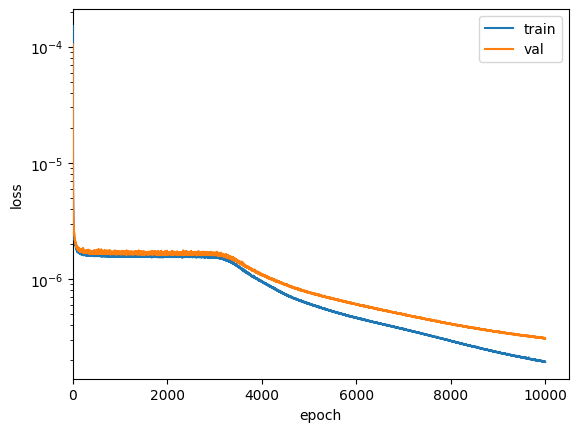

In [18]:
plt.semilogy(loss['train'], label='train', zorder=10)
plt.semilogy(loss['val'], label='val', zorder=10)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xlim(0,)
plt.legend()

In [20]:
state_dict = torch.load('./models/DKI_data_MSELoss_net.pt')
net = Net(100, 100, layers=[100])
net.load_state_dict(state_dict)

<All keys matched successfully>

In [21]:
import torch.nn.functional as F

In [22]:
X, Y = process_data('./data/DKI_data/Ptrain.csv')
K = calculate_keystone_array(X, Y, net)

100%|██████████| 500/500 [00:01<00:00, 307.35it/s]


/var/folders/ly/crjxkl596x59j9mv3_2mw1_00000gn/T/ipykernel_65399/2706379761.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted = net(torch.tensor(x_batch[i]).unsqueeze(0))


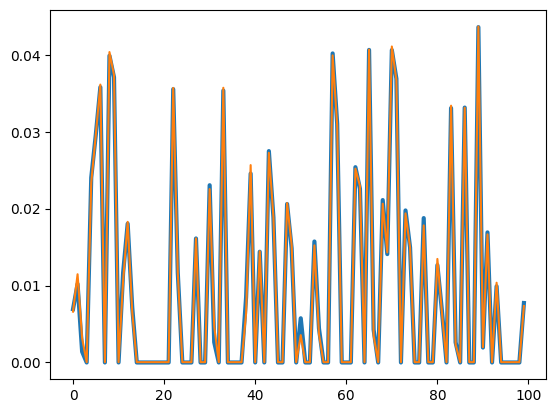

In [23]:
x_batch, y_batch = next(iter(val_loader))
i = 1
predicted = net(torch.tensor(x_batch[i]).unsqueeze(0))
plt.plot(y_batch[i], label='true', lw=3)
plt.plot(predicted.detach().numpy().T, label='predicted')

<Axes: >

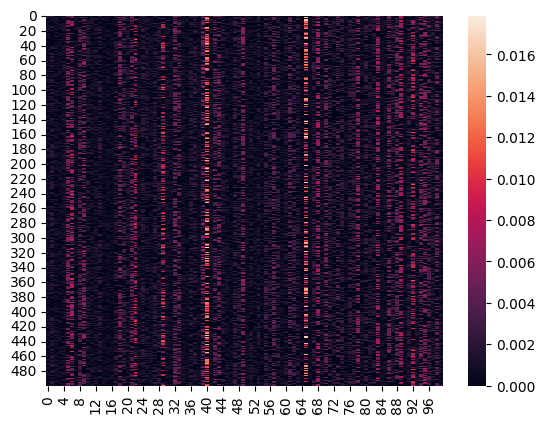

In [24]:
sns.heatmap(K)

In [25]:
indices = np.where(K.T != 0)
non_zero = np.array([(i+1, j+1, K.T[i,j]) for i, j in zip(indices[0], indices[1])])
dataframe = pd.DataFrame(non_zero, columns=['i', 'j', 'K[i,j]'])
my_keystones = dataframe["K[i,j]"].values

DKI_keystone = np.genfromtxt('./data/DKI_data/keystoness_species.csv', delimiter=',')[1:,:]
pred_keystones = DKI_keystone[:,0]
true_keystones = DKI_keystone[:,2]

In [26]:
# save as csv
np.savetxt('results/keystoness.csv', K, delimiter=',', header='i,j,K[i,j]')

In [27]:
import pandas as pd
dataframe = pd.DataFrame(non_zero, columns=['Species', 'Sample', 'Structural Keystoness'])
dataframe.tail(20)

,Species,Sample,Structural Keystoness
24980,100.0,459.0,0.001347
24981,100.0,461.0,0.001595
24982,100.0,462.0,0.001455
24983,100.0,463.0,0.001651
24984,100.0,467.0,0.001754
24985,100.0,468.0,0.001406
24986,100.0,470.0,0.001573
24987,100.0,471.0,0.001528
24988,100.0,473.0,0.001458
24989,100.0,474.0,0.001586


Text(0.5, 0, 'True keystones')

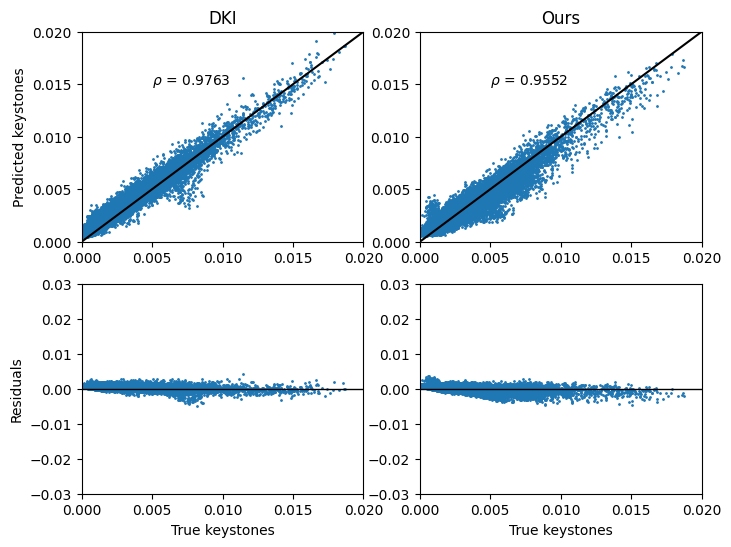

In [28]:

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(figsize=(8,6), ncols=2, nrows=2)
# fig.tight_layout()
ax1.scatter(true_keystones, pred_keystones, s=1)
ax1.plot([0,0.03], [0,0.03], 'k-')
ax1.set_xlim(0,0.02)
ax1.set_ylim(0,0.02)
# ax1.set_xlabel('True keystones')
ax1.set_ylabel('Predicted keystones')
ax1.set_title('DKI')

ax2.scatter(true_keystones, my_keystones, s=1)
ax2.plot([0,0.03], [0,0.03], 'k-')
ax2.set_xlim(0,0.02)
ax2.set_ylim(0,0.02)
# ax2.set_xlabel('True keystones')
ax2.set_title('Ours')

# correlation
from scipy.stats import pearsonr
ax1.text(0.005,0.015,f"${{\\rho}}$ = {pearsonr(true_keystones, pred_keystones)[0]:.4f}")
ax2.text(0.005,0.015,f"${{\\rho}}$ = {pearsonr(true_keystones, my_keystones)[0]:.4f}")

ax3.scatter(true_keystones, pred_keystones-true_keystones, s=1)
ax3.axhline(0, color='k', lw=1)
ax3.set_xlim(0,0.02)
ax3.set_ylim(-0.03,0.03)
ax3.set_xlabel('True keystones')
ax3.set_ylabel('Residuals')

ax4.scatter(true_keystones, my_keystones-true_keystones, s=1)
ax4.axhline(0, color='k', lw=1)
ax4.set_xlim(0,0.02)
ax4.set_ylim(-0.03,0.03)
ax4.set_xlabel('True keystones')


This model is highly sensitive to hyperparameters. You can definitely get better results than this. I would expect that KLDivLoss would be the way to go here, since you're comparing probability distributions, but it seemed more challenging to get good results. In this example, I've just used MSELoss.

# European Data

In [59]:
training_params = SimpleNamespace(
        file_path = './data/expt_data/Ptrain_NA.csv',
        batch_size = 32,
        val_size = 0.1,
        lr = 0.05,
        epochs = 500,
        verbosity = 10,
        layers = [1024],
        output_name = 'EU_data',
    )

In [60]:
loss, model, train_loader, val_loader = train(training_params)

Epoch: 0 	Training Loss: 8.08e-05 	Validation Loss: 7.91e-05
Epoch: 10 	Training Loss: 6.36e-05 	Validation Loss: 6.34e-05
Epoch: 20 	Training Loss: 5.88e-05 	Validation Loss: 5.75e-05
Epoch: 30 	Training Loss: 5.54e-05 	Validation Loss: 5.42e-05
Epoch: 40 	Training Loss: 5.17e-05 	Validation Loss: 5.06e-05
Epoch: 50 	Training Loss: 4.89e-05 	Validation Loss: 4.76e-05
Epoch: 60 	Training Loss: 4.47e-05 	Validation Loss: 4.29e-05
Epoch: 70 	Training Loss: 4.14e-05 	Validation Loss: 3.93e-05
Epoch: 80 	Training Loss: 3.92e-05 	Validation Loss: 3.74e-05
Epoch: 90 	Training Loss: 3.70e-05 	Validation Loss: 3.61e-05
Epoch: 100 	Training Loss: 3.47e-05 	Validation Loss: 3.40e-05
Epoch: 110 	Training Loss: 3.29e-05 	Validation Loss: 3.30e-05
Epoch: 120 	Training Loss: 3.20e-05 	Validation Loss: 3.21e-05
Epoch: 130 	Training Loss: 3.13e-05 	Validation Loss: 3.17e-05
Epoch: 140 	Training Loss: 3.02e-05 	Validation Loss: 3.14e-05
Epoch: 150 	Training Loss: 2.95e-05 	Validation Loss: 3.12e-05
Epo

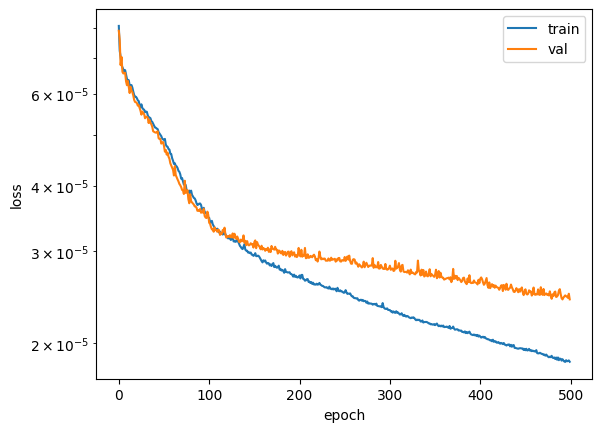

In [61]:
plt.semilogy(loss['train'], label='train')
plt.semilogy(loss['val'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [62]:
state_dict = torch.load('./models/EU_data_net.pt')
net = Net(1324, 1324, layers=[1024])

net.load_state_dict(state_dict)

<All keys matched successfully>

In [63]:
X, Y = process_data('./data/expt_data/Ptrain_NA.csv')
K = calculate_keystone_array(X, Y, net)

100%|██████████| 2971/2971 [03:48<00:00, 13.00it/s]


In [134]:
Y.shape

(2971, 1324)

<Axes: >

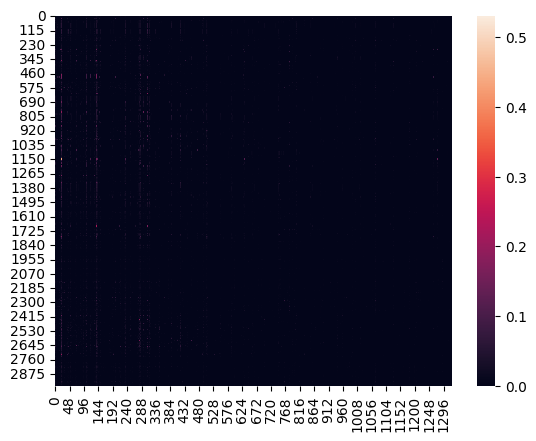

In [67]:
import seaborn as sns
sns.heatmap(K)

Text(0.5, 1.0, 'EU data keystoness')

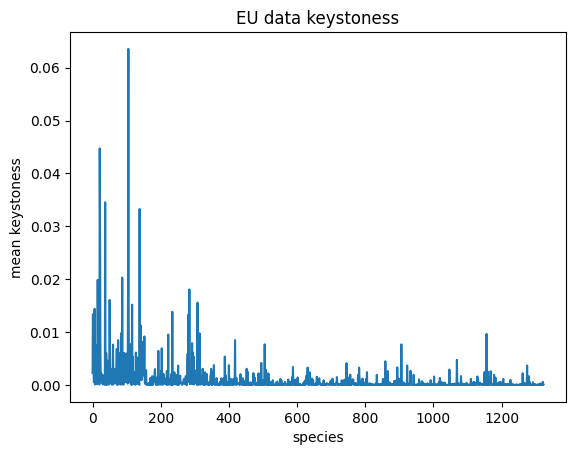

In [81]:
plt.plot(K.mean(axis=0))
plt.xlabel('species')
plt.ylabel('mean keystoness')
plt.title('EU data keystoness')

/var/folders/ly/crjxkl596x59j9mv3_2mw1_00000gn/T/ipykernel_65399/2522499.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted = net(torch.tensor(x_batch[i]).unsqueeze(0))


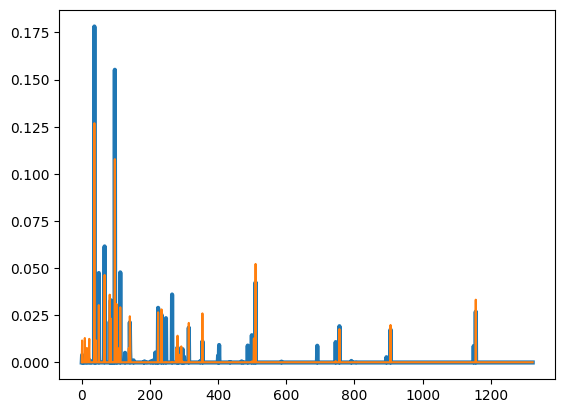

In [75]:
x_batch, y_batch = next(iter(val_loader))
i = 0
predicted = net(torch.tensor(x_batch[i]).unsqueeze(0))
plt.plot(y_batch[i], label='true', lw=3)
plt.plot(predicted.detach().numpy().T, label='predicted')

In [12]:
indices = np.where(K.T != 0)
non_zero = np.array([(i+1, j+1, K.T[i,j]) for i, j in zip(indices[0], indices[1])])
dataframe = pd.DataFrame(non_zero, columns=['i', 'j', 'K[i,j]'])
my_keystones = dataframe["K[i,j]"].values

# Implementing the Neural ODE from cNode

In [19]:
import torch
import torch.nn as nn
from torchdiffeq import odeint

In [20]:
def get_batch(ztrn,ptrn,mb_size):
    s = torch.from_numpy(np.random.choice(np.arange(ptrn.size(dim=0), dtype=np.int64), mb_size, replace=False))
    batch_p = ztrn[s,:]
    batch_q = ptrn[s,:]
    batch_t = torch.tensor(np.linspace(0, 1, 100, endpoint=False), dtype=torch.float32)
    return batch_p.to(device), batch_q.to(device), batch_t.to(device)


def loss_bc(p_i, q_i):
    return torch.sum(torch.abs(p_i-q_i))/torch.sum(torch.abs(p_i+q_i))


def process_data(P):
    Z = P.copy()
    Z[Z>0] = 1
    P = P/P.sum(axis=0)[np.newaxis,:]
    Z = Z/Z.sum(axis=0)[np.newaxis,:]
    
    P = P.astype(np.float32)
    Z = Z.astype(np.float32)

    P = torch.from_numpy(P.T)
    Z = torch.from_numpy(Z.T)
    return P,Z


class ODEFunc(torch.nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.fcc1 = torch.nn.Linear(N, N)
        self.fcc2 = torch.nn.Linear(N, N)

    def forward(self, t, y):
        out = self.fcc1(y)
        out = nn.ReLU()(out)
        out = self.fcc2(out)
        f = torch.matmul(torch.matmul(torch.ones(y.size(dim=1),1),y),torch.transpose(out,0,1))
        return torch.mul(y,out-torch.transpose(f,0,1))

In [21]:
from tqdm import tqdm
import copy
import numpy as np

In [22]:
def train_reptile(max_epochs,mb,LR,ztrn,ptrn,zval,pval):
    loss_train = []
    loss_val = []
    
    func = ODEFunc().to(device)
    optimizer = torch.optim.Adam(func.parameters(), lr=LR)

    Loss_opt = 1
    loop_obj = tqdm(range(max_epochs))
    for e in loop_obj:
        
        func.train()
        optimizer.zero_grad()
        batch_p, batch_q, batch_t = get_batch(ztrn,ptrn,mb)
        
        for i in range(mb):
            p_pred = odeint(func,batch_p[i].unsqueeze(dim=0),batch_t)
            p_pred = torch.reshape(p_pred[-1,:,:],(1,N))
            if i==0:
                loss = loss_bc(p_pred.unsqueeze(dim=0),batch_q[i].unsqueeze(dim=0))
            else:
                loss = loss + loss_bc(p_pred.unsqueeze(dim=0),batch_q[i].unsqueeze(dim=0))
                
        loss_train.append(loss.item()/mb)

        func.zero_grad()
        loss.backward()
        optimizer.step()

        func.eval()
        for i in range(zval.size(dim=0)):
            with torch.no_grad():
                p_pred = odeint(func,zval[i].unsqueeze(dim=0),batch_t)
            p_pred = torch.reshape(p_pred[-1,:,:],(1,N))
            if i==0:
                l_val = loss_bc(p_pred.unsqueeze(dim=0),pval[i].unsqueeze(dim=0))
            else:
                l_val = l_val + loss_bc(p_pred.unsqueeze(dim=0),pval[i].unsqueeze(dim=0))
        loss_val.append(l_val.item()/zval.size(dim=0))
        if l_val.item()/zval.size(dim=0)<=Loss_opt:
            Loss_opt = loss_val[-1]
            best_model = copy.deepcopy(func)

        # update the neural network
        

        loop_obj.set_postfix_str(f"epoch: {e+1}, train loss: {loss_train[-1]:.4f} val loss: {loss_val[-1]:.4f}")
        

    return best_model, loss_train, loss_val

In [23]:
# hyperparameters
max_epochs = 100
device = 'cpu'
batch_time = 100
t = torch.arange(0.0, batch_time, 0.01)

# load the dataset
filepath_train = './data/DKI_data/Ptrain.csv'
# filepath_test = './data/DKI_data/Ptest.csv' # Replace "Ptest.csv" with "Ztest.csv" for real dataset.



In [24]:
P = np.loadtxt(filepath_train,delimiter=',')
number_of_cols = P.shape[1]
random_indices = np.random.choice(number_of_cols, size=int(0.2*number_of_cols), replace=False)
P_val = P[:,random_indices]
P_train =  P[:,np.setdiff1d(range(0,number_of_cols),random_indices)]
ptrn,ztrn = process_data(P_train)
pval,zval = process_data(P_val)
pall,zall = process_data(P)

M, N = ptrn.shape

In [25]:
LR = 0.01
mb = 20

best_model, loss_train, loss_val = train_reptile(max_epochs,mb,LR,ztrn.to(device),ptrn.to(device),zval.to(device),pval.to(device))

100%|██████████| 100/100 [01:56<00:00,  1.16s/it, epoch: 100, train loss: 0.0321 val loss: 0.0332]


Text(0, 0.5, 'Loss')

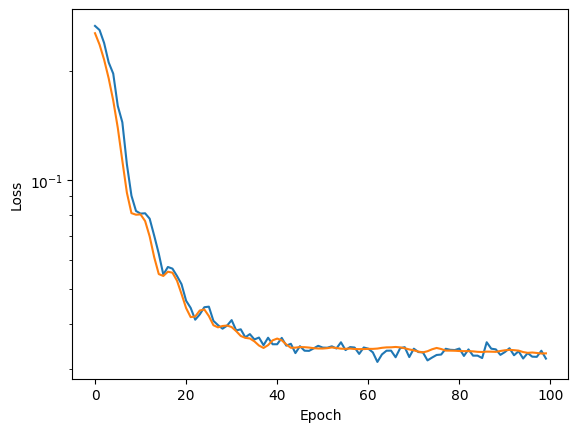

In [26]:
import matplotlib.pyplot as plt

plt.semilogy(loss_train)
plt.plot(loss_val)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [30]:
X, Y = process_data('./data/DKI_data/Ptrain.csv')
K = calculate_keystone_array(X, Y, best_model)

AttributeError: 'str' object has no attribute 'copy'

In [ ]:
indices = np.where(K.T != 0)
non_zero = np.array([(i+1, j+1, K.T[i,j]) for i, j in zip(indices[0], indices[1])])
dataframe = pd.DataFrame(non_zero, columns=['i', 'j', 'K[i,j]'])
my_keystones = dataframe["K[i,j]"].values

DKI_keystone = np.genfromtxt('./data/DKI_data/keystoness_species.csv', delimiter=',')[1:,:]
pred_keystones = DKI_keystone[:,0]
true_keystones = DKI_keystone[:,2]

import pandas as pd
dataframe = pd.DataFrame(non_zero, columns=['Species', 'Sample', 'Structural Keystoness'])


fig, (ax1, ax2) = plt.subplots(figsize=(8,4), ncols=2, sharey=True)
fig.tight_layout()
ax1.scatter(true_keystones, pred_keystones, s=1)
ax1.plot([0,0.03], [0,0.03], 'k-')
ax1.set_xlim(0,0.03)
ax1.set_ylim(0,0.03)
ax1.set_xlabel('True keystones')
ax1.set_ylabel('Predicted keystones')
ax1.set_title('DKI')

ax2.scatter(true_keystones, my_keystones, s=1)
ax2.plot([0,0.03], [0,0.03], 'k-')
ax2.set_xlim(0,0.03)
ax2.set_ylim(0,0.03)
ax2.set_xlabel('True keystones')
ax2.set_title('Ours')

# correlation
from scipy.stats import pearsonr
ax1.text(0.005,0.02,f"${{\\rho}}$ = {pearsonr(true_keystones, pred_keystones)[0]:.4f}")
ax2.text(0.005,0.02,f"${{\\rho}}$ = {pearsonr(true_keystones, my_keystones)[0]:.4f}")


In [28]:
batch_t = torch.tensor(np.linspace(0, 1, 100, endpoint=False), dtype=torch.float32)
p_pred = odeint(best_model, torch.tensor(X[0]).unsqueeze(dim=0), batch_t)[-1,:,:]
# torch.reshape(p_pred[-1,:,:],(1,N))

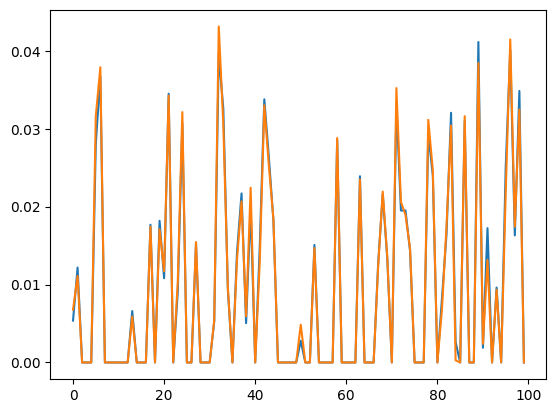

In [29]:
plt.plot(p_pred.detach().numpy().flatten())
plt.plot(Y[0])

In [31]:
import numpy as np
import torch
from scipy.spatial import distance
from tqdm import tqdm


def calculate_keystone(j, sample, original_abundance, model):
    # if the abundance is already zero, then the keystone index is zero
    p = original_abundance[j]

    if p == 0:
        return 0

    new_sample = sample.copy()

    sample = torch.tensor(sample, dtype=torch.float32)
    new_sample = torch.tensor(new_sample, dtype=torch.float32)
    with torch.no_grad():
        new_abundance = odeint(best_model, sample.reshape(1, -1), batch_t)[-1,:,:].detach().numpy().flatten()
        # new_abundance = model(torch.tensor(sample.reshape(1, -1), dtype=torch.float32)).numpy().flatten()

    new_sample[j] = 0
    new_abundance[j] = 0

    null_abundance = new_abundance / new_abundance.sum()

    with torch.no_grad():
        # predicted_abundance = model(torch.tensor(new_sample.reshape(1, -1), dtype=torch.float32)).numpy()
        predicted_abundance = odeint(best_model, new_sample.reshape(1, -1), batch_t)[-1,:,:].detach().numpy().flatten()
    
    k = distance.braycurtis(null_abundance, predicted_abundance.flatten()) * (1 - p)

    return k



def calculate_keystone_array(sample_array, sample_abundances, model):
    K = np.zeros((sample_array.shape[0], sample_array.shape[1]))

    for i, sample in enumerate(tqdm(sample_array)):
        original_abundance = sample_abundances[i]
        for j, _ in enumerate(sample):
            K[i, j] = calculate_keystone(j, sample, original_abundance, model)
            
    return K

In [32]:
K = calculate_keystone_array(X, Y, best_model)

100%|██████████| 500/500 [06:15<00:00,  1.33it/s]


<Axes: >

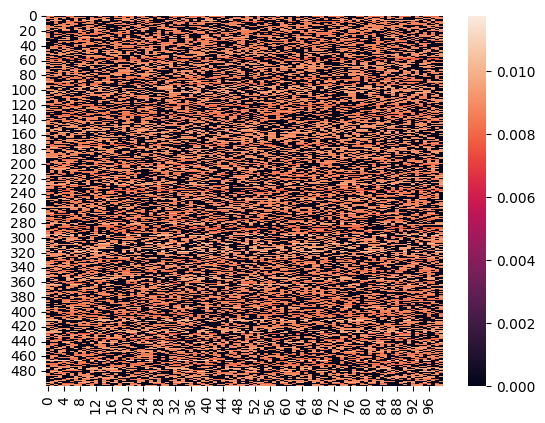

In [33]:
sns.heatmap(K)